In [24]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import pickle



ModuleNotFoundError: No module named 'xgboost'

In [2]:
df = pd.read_csv("amazon_reviews_big.csv")
df.head()


,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000HDJXNA,1,What I recieved is not what is pictured here O...,"12 26, 2012",A29YXBFTD7QUP3,HHA,Buyer be ware,1.356480e+09
1,B006KKS7XQ,5,Excellent unit and a pretty simple install usi...,"09 20, 2013",A3IMTXFYD7CGDN,"Peter W. George ""soyflakeman""",high quality without high price,1.379635e+09
2,B002NP8XJ0,5,"I'm enjoying this keyboard, I'm getting anothe...","08 31, 2010",AXNOW20FQKHVW,B. Hayashi,Superb keyboard + solution for slow wake up an...,1.283213e+09
3,B000EITTLE,4,"Overall, this is a fantastic camera that I'm e...","02 3, 2008",A10KCAK279LO0W,"mmcwatters ""macdadi80""",One qualm: not great in low light,1.201997e+09
4,B006CRXK4S,5,These work very well with mySamsung PN64D7000 ...,"01 28, 2012",A19XXLMZXR764J,S. Garfinkle,"Work great, fit well",1.327709e+09


In [3]:
df.drop(columns=['asin', 'reviewTime', 'reviewerID','reviewerName','summary','unixReviewTime'], axis=1, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     100000 non-null  int64 
 1   reviewText  99934 non-null   object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
df.isnull().sum()  # Check how many missing values there are in each column


overall        0
reviewText    66
dtype: int64

In [6]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [7]:
df['overall'] = df['overall'].apply(lambda x: 0 if x <= 3 else 1)


In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
word_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emojis
    text = re.sub(r'[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]', '', text)
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word_lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['processed_review'] = df['reviewText'].apply(preprocess_text)
corpus = df['processed_review'].tolist()

In [10]:
df = df.drop(columns='reviewText',axis=1)
df.head()

,overall,processed_review
0,0,recieved pictured advertized vidio cable job n...
1,1,excellent unit pretty simple install using wir...
2,1,enjoying keyboard getting another one laptop k...
3,1,overall fantastic camera extremely pleased how...
4,1,work well mysamsung pn inch p hz plasma hdtv b...


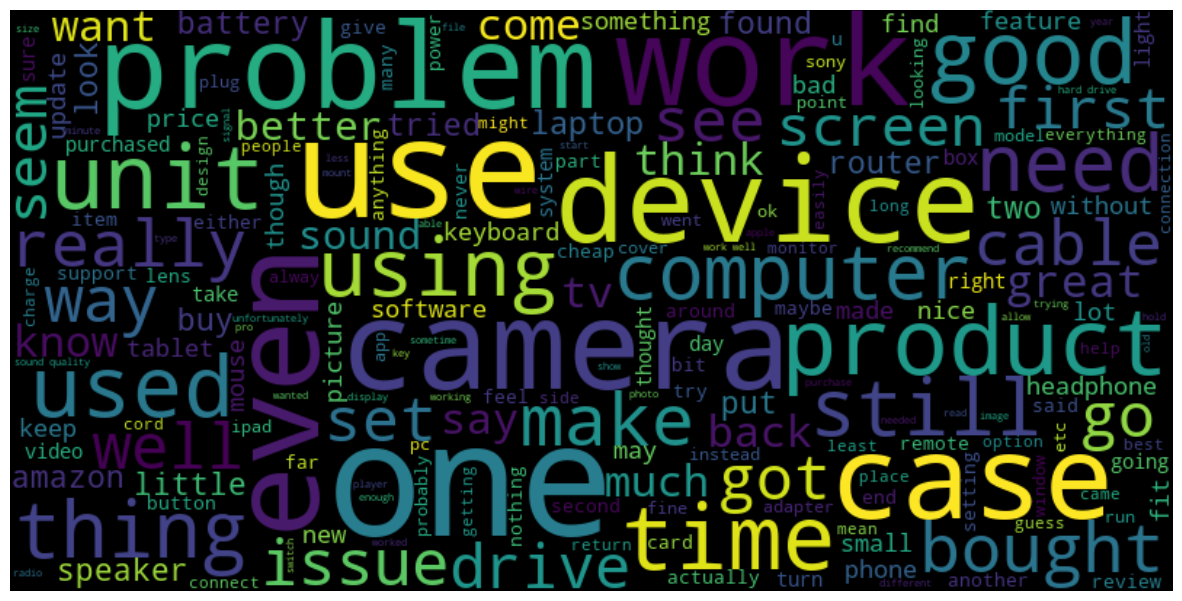

In [11]:
consolidated=' '.join(word for word in df['processed_review'][df['overall']==0].astype(str))
wordCloud=WordCloud(width=800,height=400,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

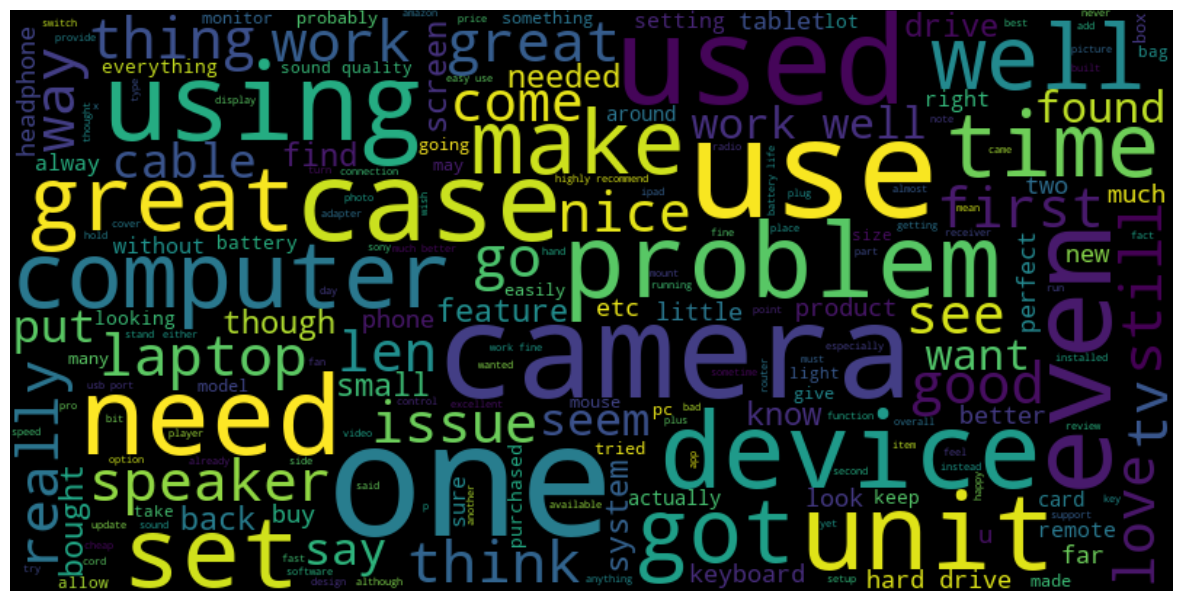

In [12]:
consolidated=' '.join(word for word in df['processed_review'][df['overall']==1].astype(str))
wordCloud=WordCloud(width=800,height=400,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
df['overall'].value_counts()

overall
1    80190
0    19744
Name: count, dtype: int64

In [14]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X = tfidf.fit_transform(corpus).toarray()


In [15]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(99934, 4000))

In [16]:
tfidf.vocabulary_

{'cable': np.int64(433),
 'job': np.int64(1743),
 'needed': np.int64(2210),
 'looking': np.int64(1953),
 'high': np.int64(1571),
 'quality': np.int64(2692),
 'buy': np.int64(423),
 'product': np.int64(2630),
 'cheap': np.int64(548),
 'thin': np.int64(3459),
 'flimsy': np.int64(1259),
 'gold': np.int64(1422),
 'anything': np.int64(143),
 'else': np.int64(1013),
 'claim': np.int64(572),
 'switch': np.int64(3378),
 'mistake': np.int64(2121),
 'order': np.int64(2354),
 'know': np.int64(1781),
 'attempt': np.int64(197),
 'contact': np.int64(688),
 'find': np.int64(1206),
 'contacted': np.int64(689),
 'seller': np.int64(3015),
 'told': np.int64(3517),
 'amazon': np.int64(112),
 'com': np.int64(608),
 'good': np.int64(1425),
 'enough': np.int64(1035),
 'give': np.int64(1400),
 'refund': np.int64(2814),
 'run': np.int64(2929),
 'wife': np.int64(3844),
 'tv': np.int64(3594),
 'thing': np.int64(3460),
 'would': np.int64(3928),
 'sent': np.int64(3026),
 'back': np.int64(223),
 'full': np.int64(13

In [17]:
y = df['overall']

In [18]:
y.value_counts()  

overall
1    80190
0    19744
Name: count, dtype: int64

In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [20]:
y_resampled.value_counts()

overall
0    80190
1    80190
Name: count, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Classification Report:\n", report)

# Confusion Matrix Visualization
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy Score: 0.8590223219852849
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86     16166
           1       0.87      0.84      0.86     15910

    accuracy                           0.86     32076
   macro avg       0.86      0.86      0.86     32076
weighted avg       0.86      0.86      0.86     32076



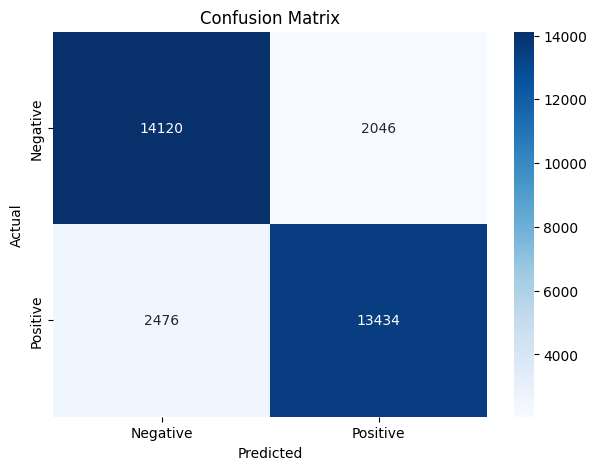

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print accuracy score
print("Accuracy Score:", accuracy)
print("Classification Report:\n", report)
# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [23]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
